# Disponibilità dati delle stazioni SCIA al calcolo delle normali climatiche
Analizzo le serie temporali per vedere quali stazioni hanno dati sufficienti (secondo criteri WMO) al calcolo delle normali.

In [10]:
library(ggplot2, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))

source("src/load/load.R")
tvar <- "T_MIN"
starting_year <- 2005
years <- 2023 - starting_year + 1

In [2]:
m.scia <- load.metadata("SCIA", tvar) |> filter(last_year >= 2005)
scia <- read.series("SCIA", tvar) |>
    semi_join(m.scia, by = "identifier") |>
    filter(year(date) >= starting_year) |>
    fill_gaps(.full = FALSE)
# source("src/load/load_utils.R")
# write_to_cache(scia, c("SCIA", tvar), suffix = "_2005gaps", cache_section = "cache/series")
# scia <- load.series("SCIA", tvar, .suffix = "_2005gaps")


Cache found: SCIA/T_MIN, suffix: <>, loading from disk



In [3]:
#' Asserts the availability of a series of values coming from a complete monthly set of data for climate normal computation by WMO standards
#'
#' @param series The time series of recorded values for a given month
is.month.available <- function(series) {
    na_values <- is.na(series)
    (sum(na_values) < 11) && (with(rle(na_values), all(lengths[values] < 5)))
}

#' Asserts the availability of a series of monthly availabilities (as returned by \code{is.month.available}) for climate normal computation by WMO standards
#'
#' @param monthly_availability The vector of availabilities for a given month (e.g.: Jan 2005, Jan 2006, Jan 2007, ...)
is.climatology.available <- function(monthly_availability) {
    sum(monthly_availability) / length(monthly_availability) >= 0.8
}

In [4]:
avail <- scia |>
    group_by_key() |>
    index_by(year_month = ~ yearmonth(.)) |>
    summarise(available = is.month.available(T_MIN))
    
counts <- avail |>
    group_by_key() |>
    index_by(month = ~ month(., label = TRUE)) |>
    summarise(n = sum(available))


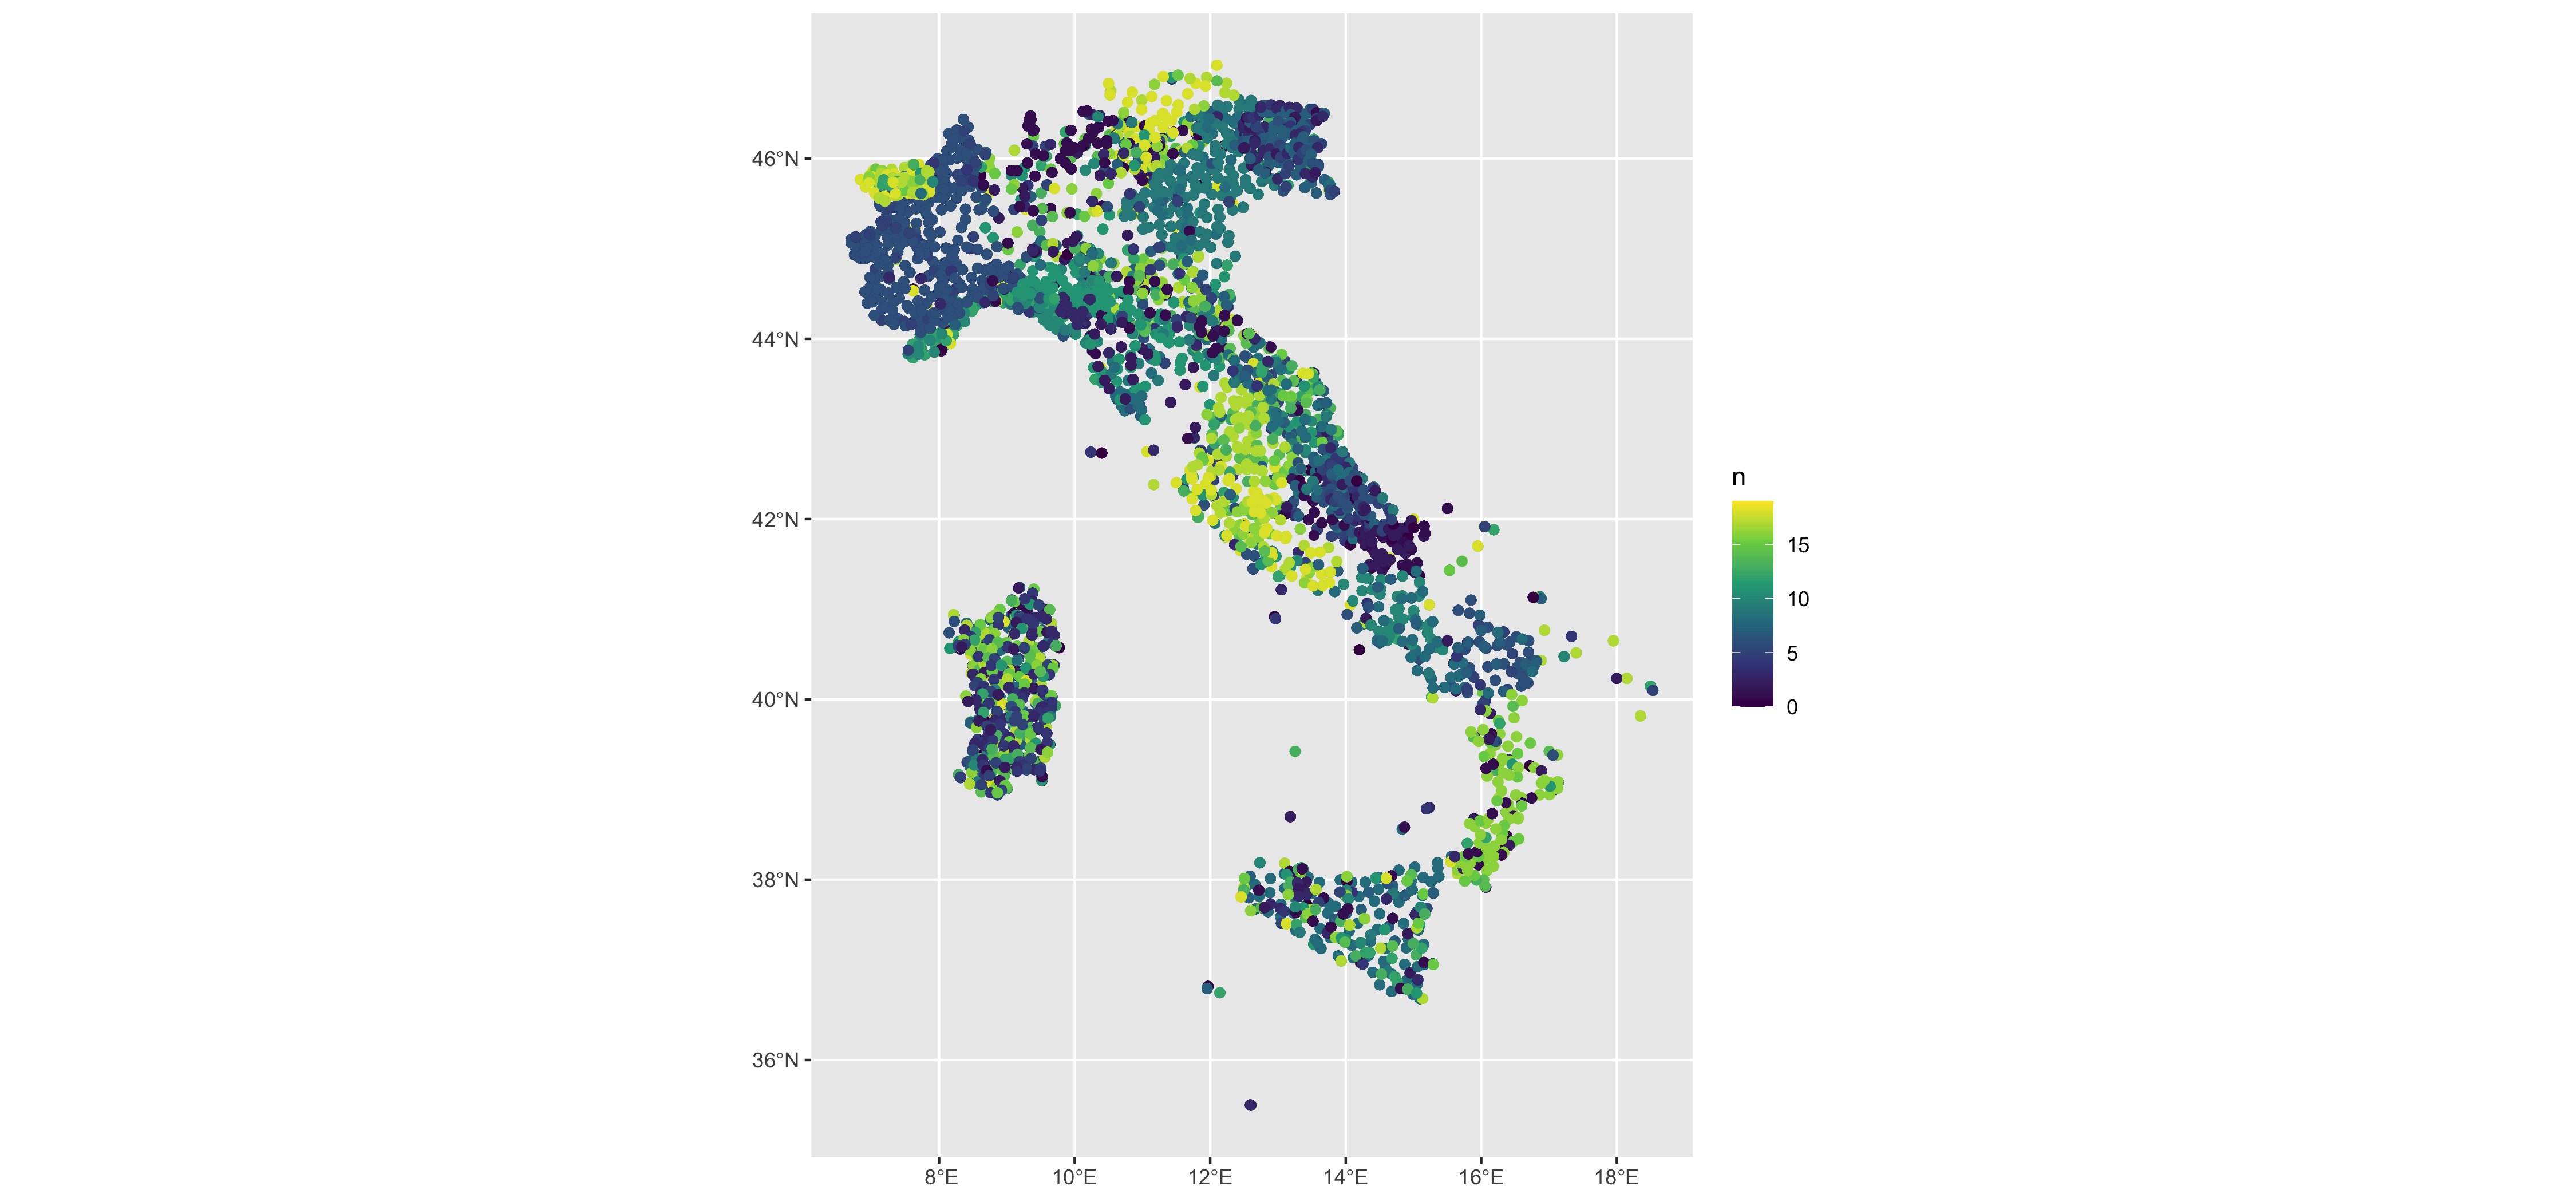

In [5]:
library(sf)
counts |>
    left_join(m.scia |> select(identifier), by = "identifier") |>
    st_as_sf() |>
    ggplot() +
    geom_sf(aes(color = n)) +
    scale_color_continuous(type = "viridis")


In [22]:
clim_availablility <- avail |>
    group_by_key() |>
    index_by(month = ~ month(., label = TRUE)) |>
    summarise(suitable_for_climatology = is.climatology.available(available)) |> left_join(m.scia |> select(identifier), by = "identifier") |> st_as_sf()

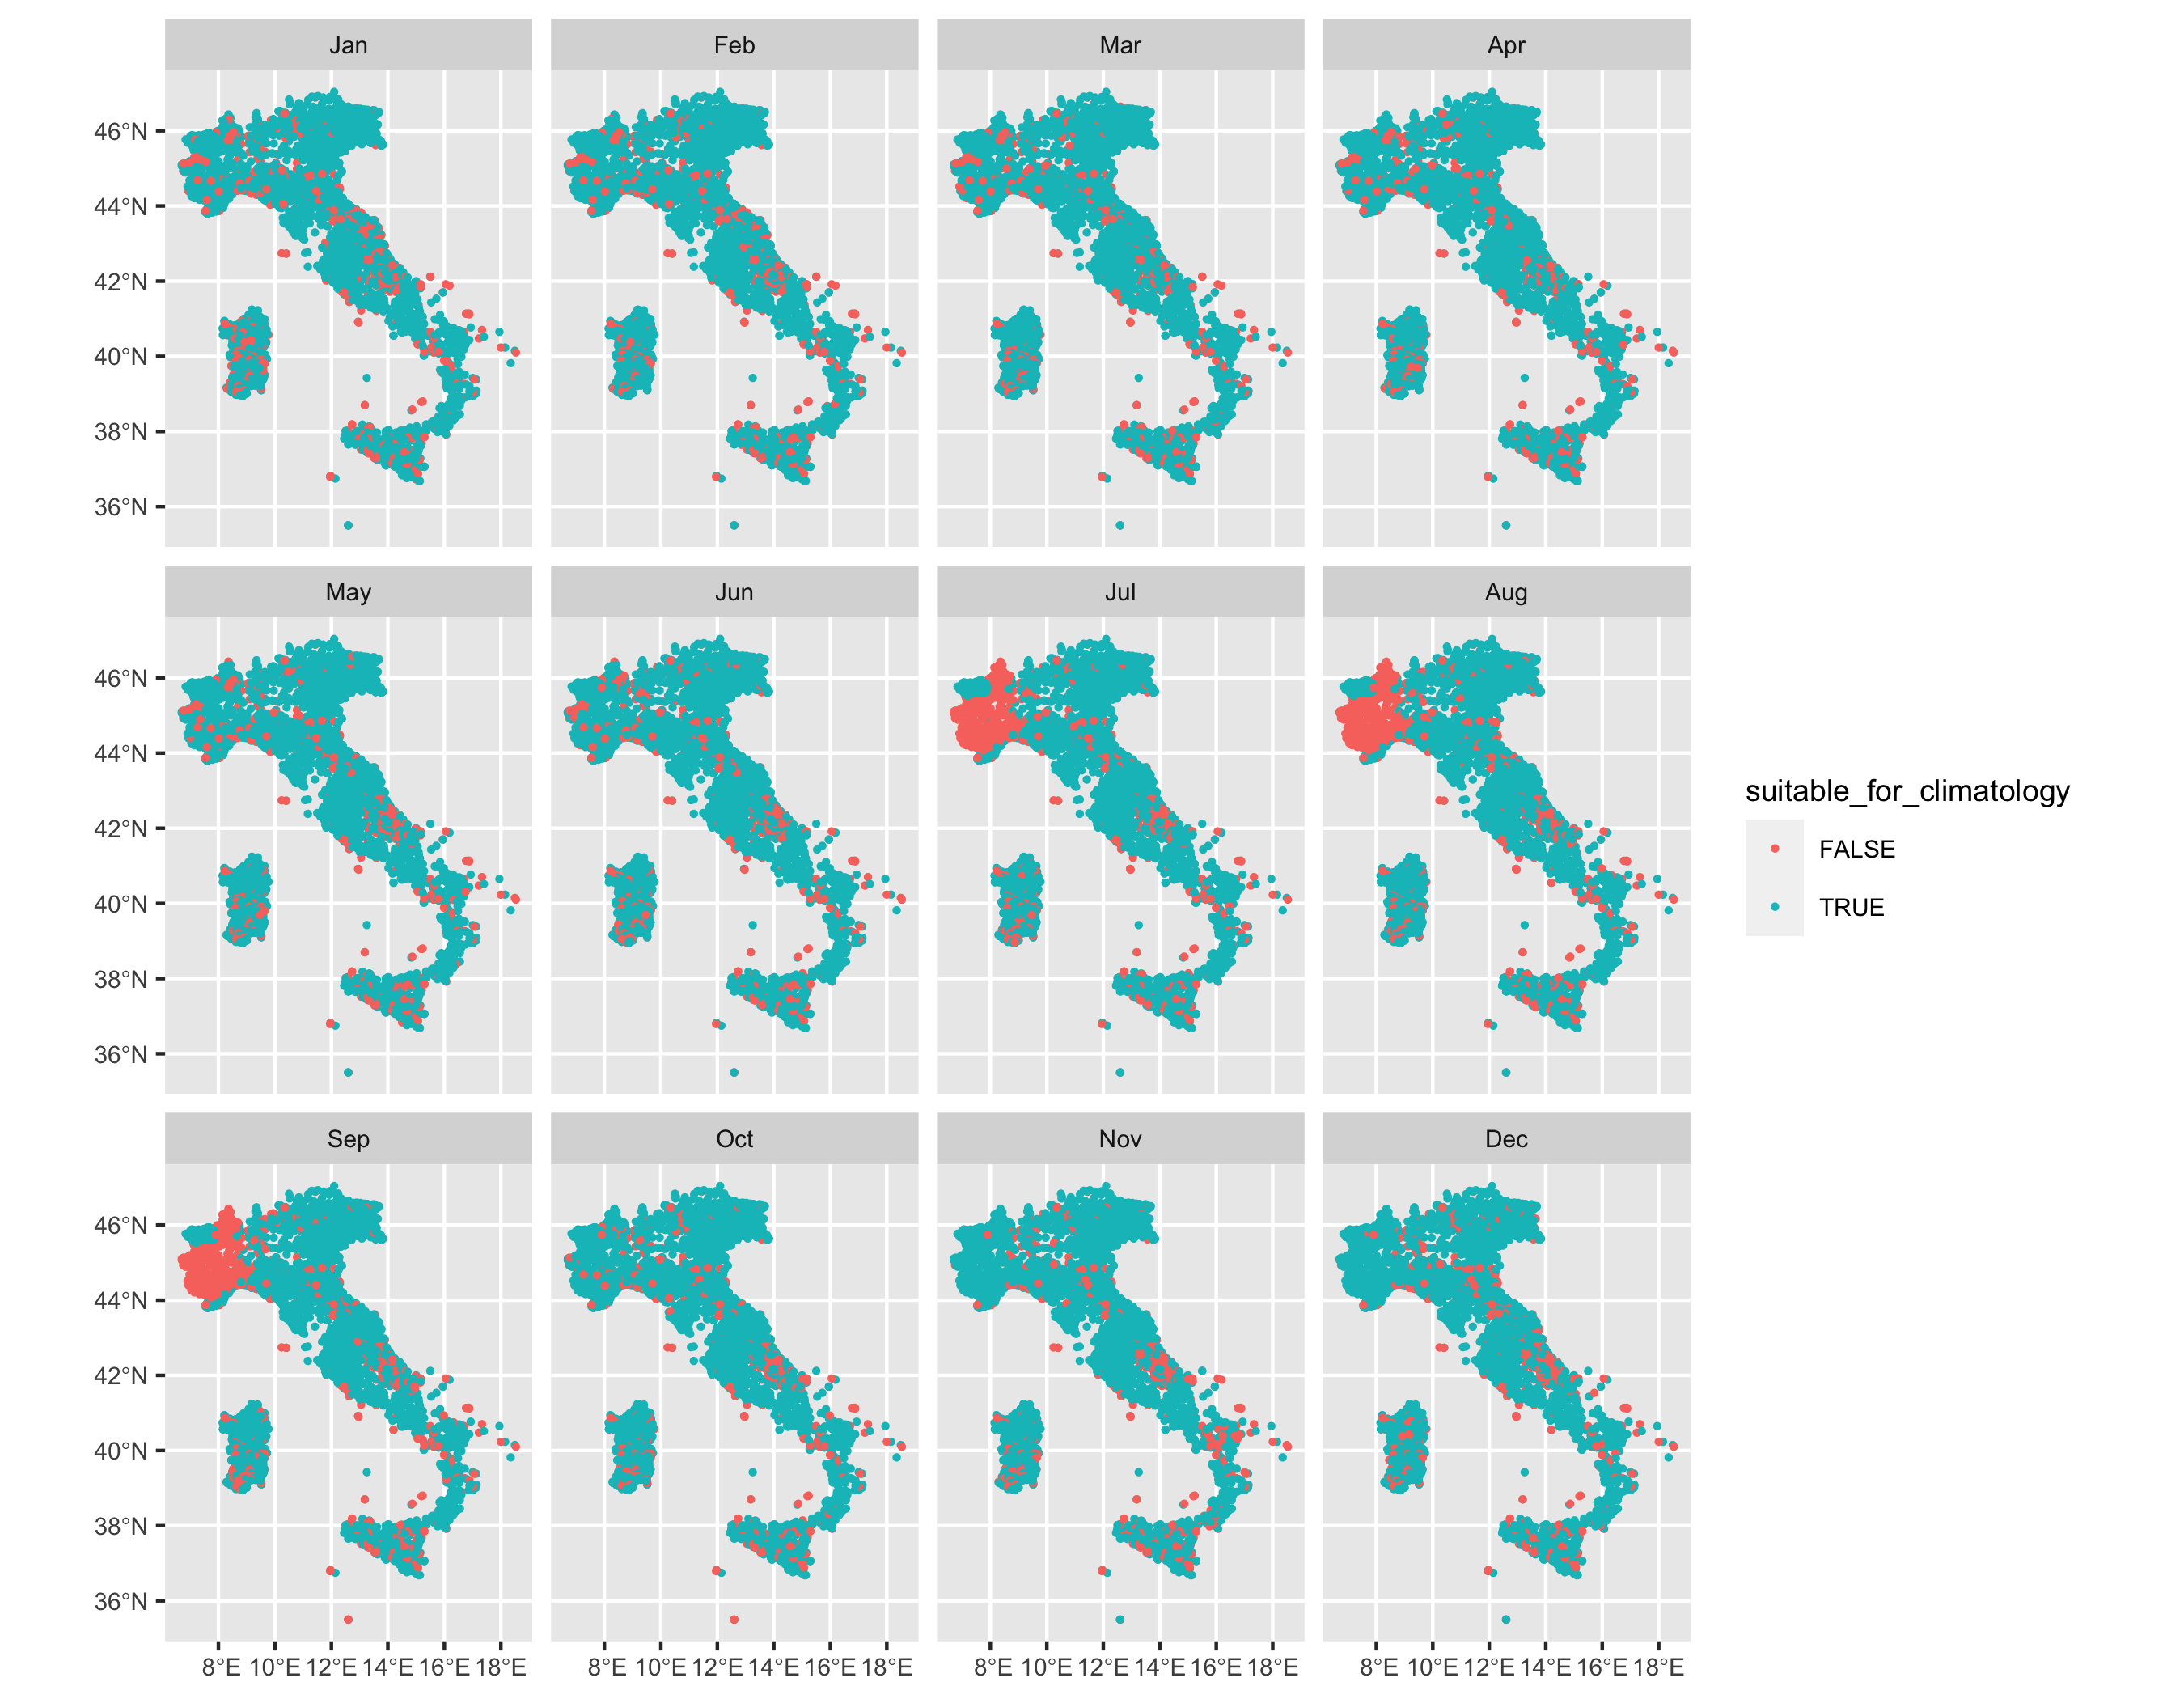

In [23]:
clim_availablility |>
    ggplot() + geom_sf(aes(color = suitable_for_climatology), size = rel(0.5)) + facet_wrap(~ month) + theme(text = element_text(size = 9)) + scale_x_continuous(guide = guide_axis(n.dodge = 2))

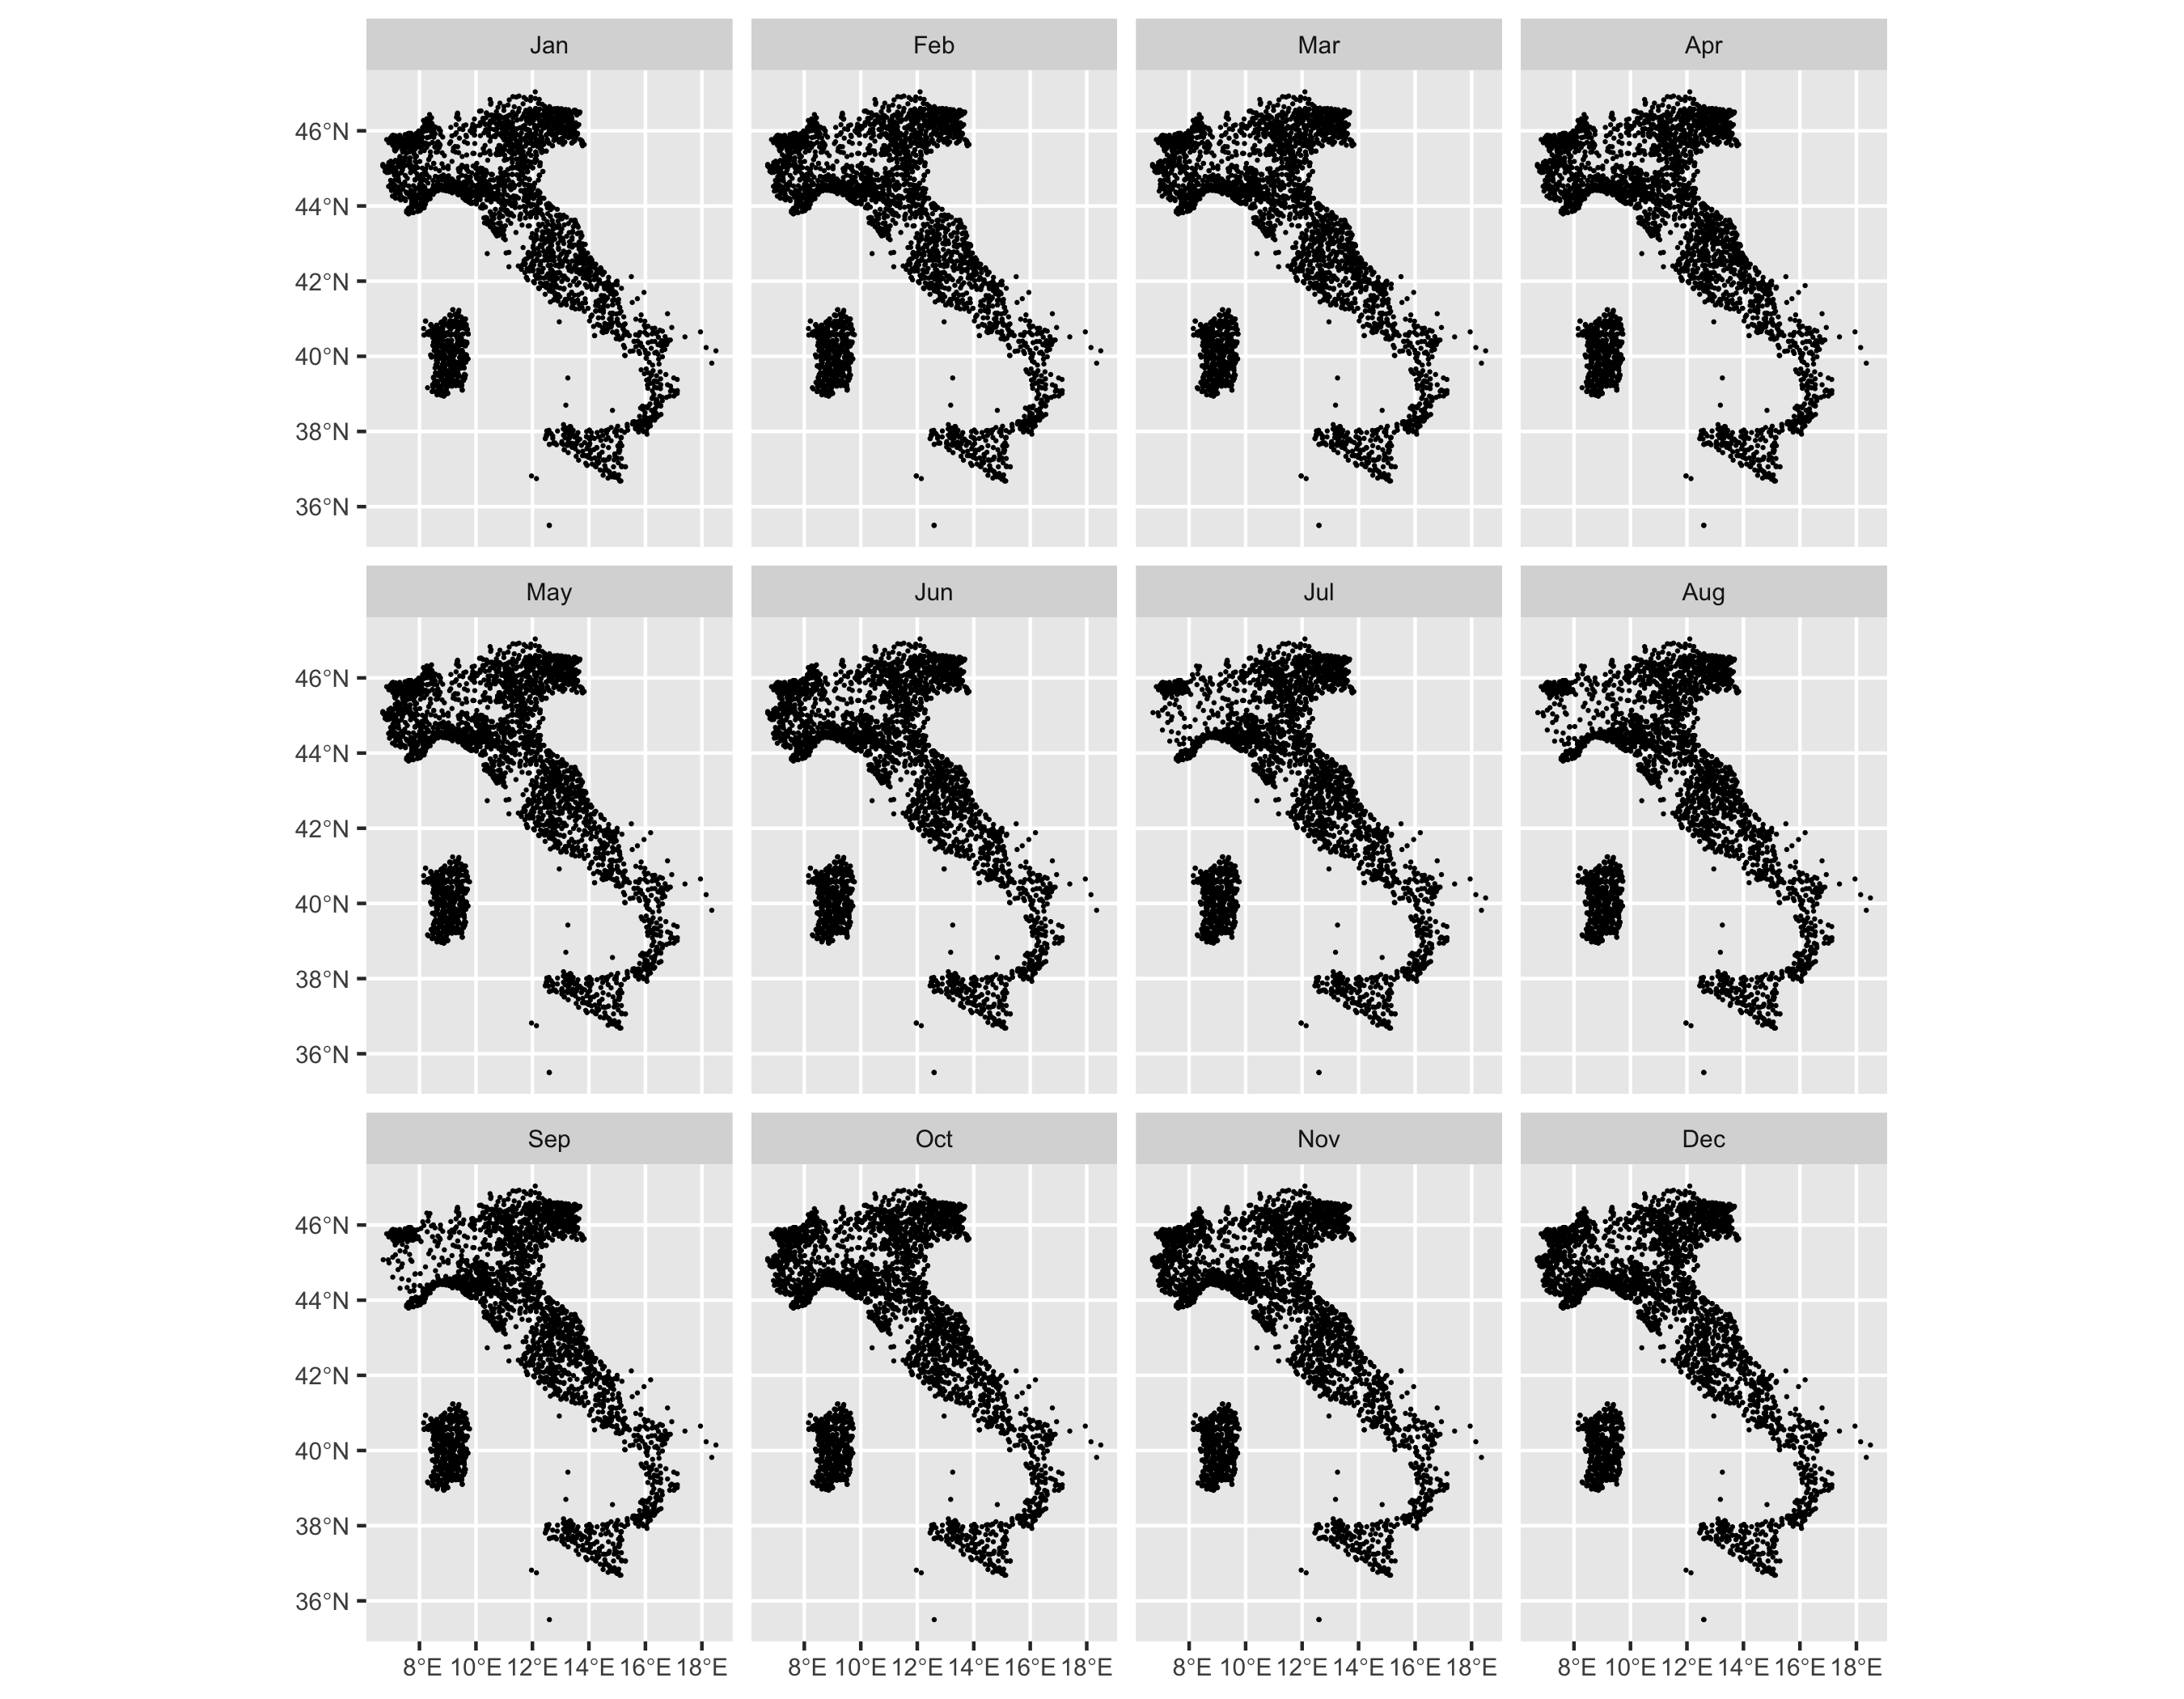

In [28]:
clim_availablility |> filter(suitable_for_climatology) |>
    ggplot() + geom_sf(size = rel(0.05)) + facet_wrap(~ month) + theme(text = element_text(size = 9)) + scale_x_continuous(guide = guide_axis(n.dodge = 2))